In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import geopy
from geopy.geocoders import Nominatim

In [4]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

2023-08-09 20:39:58.228582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/submit_sample.csv')

In [4]:
train.head()

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158


In [5]:
test.head()

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,27532,western slope,2015,chevrolet,excellent,4 cylinders,gas,92553,clean,automatic,fwd,full-size,SUV,red,NaN
1,27533,roseburg,2013,nissan,like new,4 cylinders,gas,134385,salvage,automatic,fwd,mid-size,sedan,black,or
2,27534,akron / canton,2011,volkswagen,good,4 cylinders,gas,102489,clean,automatic,fwd,full-size,sedan,black,oh
3,27535,denver,2016,jeep,excellent,6 cylinders,diesel,64310,clean,automatic,4wd,mid-size,SUV,red,co
4,27536,hickory / lenoir,1999,honda,excellent,8 cylinders,gas,180839,rebuilt,automatic,4wd,mid-size,SUV,silver,nc


In [6]:
print(train.shape)
print(test.shape)

(27532, 16)
(27537, 15)


In [ ]:
# Create a geolocator object
headers = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'
geolocator = Nominatim(user_agent=headers)

# Define a function to get latitude and longitude for a given region
def get_lat_long(region):
    try:
        location = geolocator.geocode(region)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        try:
            location = geolocator.geocode(region)
            if location:
                return location.latitude, location.longitude
            else:
                return None, None
        except:
            return None, None

In [ ]:
import time
loca = []
lat = []
lon = []
for location in set(train['region']):
    latitude, longitude = get_lat_long(location)
    loca.append(location)
    lat.append(latitude)
    lon.append(longitude)
    time.sleep(1)

In [6]:
lat_long_df = pd.DataFrame()
lat_long_df['region'] = loca
lat_long_df['latitude'] = lat
lat_long_df['longitude'] = lon
lat_long_df.head()

NameError: name 'loca' is not defined

In [ ]:
lat_long_df.isnull().sum()

region       0
latitude     0
longitude    0
dtype: int64

In [ ]:
lat_long_df.to_csv('lat_long_info.csv', index = False)

In [7]:
lat_long_df = pd.read_csv('lat_long_info.csv')

In [8]:
train_prep = train.merge(lat_long_df, on = 'region', how = 'left')
train_prep = train_prep.drop(['region', 'state'], axis = 1)

In [9]:
def preprocess_text(text):
    # Full-width ASCII characters mapping
    full_width_ascii_mapping = {
        '０': '0', '１': '1', '２': '2', '３': '3', '４': '4',
        '５': '5', '６': '6', '７': '7', '８': '8', '９': '9',
        'Ａ': 'A', 'Ｂ': 'B', 'Ｃ': 'C', 'Ｄ': 'D', 'Ｅ': 'E',
        'Ｆ': 'F', 'Ｇ': 'G', 'Ｈ': 'H', 'Ｉ': 'I', 'Ｊ': 'J',
        'Ｋ': 'K', 'Ｌ': 'L', 'Ｍ': 'M', 'Ｎ': 'N', 'Ｏ': 'O',
        'Ｐ': 'P', 'Ｑ': 'Q', 'Ｒ': 'R', 'Ｓ': 'S', 'Ｔ': 'T',
        'Ｕ': 'U', 'Ｖ': 'V', 'Ｗ': 'W', 'Ｘ': 'X', 'Ｙ': 'Y',
        'Ｚ': 'Z', 'ａ': 'a', 'ｂ': 'b', 'ｃ': 'c', 'ｄ': 'd',
        'ｅ': 'e', 'ｆ': 'f', 'ｇ': 'g', 'ｈ': 'h', 'ｉ': 'i',
        'ｊ': 'j', 'ｋ': 'k', 'ｌ': 'l', 'ｍ': 'm', 'ｎ': 'n',
        'ｏ': 'o', 'ｐ': 'p', 'ｑ': 'q', 'ｒ': 'r', 'ｓ': 's',
        'ｔ': 't', 'ｕ': 'u', 'ｖ': 'v', 'ｗ': 'w', 'ｘ': 'x',
        'ｙ': 'y', 'ｚ': 'z', 'ᴄ': 'c', '−': '-', 'ー': '-',
        'α': 'a'
    }

    # Replace full-width ASCII characters with their corresponding ASCII characters
    for fw_char, ascii_char in full_width_ascii_mapping.items():
        text = text.replace(fw_char, ascii_char)

    # Remove other full-width spaces (U+3000) and regular spaces
    text = text.replace('\u3000', '').replace(' ', '').replace('-', '').lower().strip()

    return text

In [10]:
train_prep['car_age'] = 2023 - train_prep['year']

In [11]:
train_prep['cylinders'] = train_prep['cylinders'].str.extract(r'(\d+)').astype(float).fillna(-1)

In [12]:
train_prep['size'] = train_prep['size'].apply(preprocess_text)

In [13]:
train_prep['size'] = train_prep['size'].apply(lambda x: 'compact' if x == 'sub-compact' else x)

In [14]:
#train_prep['market_segment'] = train_prep['type'] + '_' + train_prep['size']

In [15]:
train_prep['automatic_transmission'] = train_prep['transmission'].apply(lambda x: 1 if x.lower() == 'automatic' else 0)
train_prep['manual_transmission'] = train_prep['transmission'].apply(lambda x: 1 if x.lower() == 'manual' else 0)

In [16]:
condition_mapping = {'excellent': 5, 'like new': 4, 'new': 3, 'good':2, 'fair': 1, 'salvage':0}
train_prep['condition'] = train_prep['condition'].map(condition_mapping)

In [17]:
train_prep['gas_fueled'] = train_prep['fuel'].apply(lambda x: 1 if x == 'gas' else 0)
train_prep['diesel_fueled'] = train_prep['fuel'].apply(lambda x: 1 if x == 'diesel' else 0)
train_prep['hybrid_fueled'] = train_prep['fuel'].apply(lambda x: 1 if x == 'hybrid' else 0)
train_prep['electric_fueled'] = train_prep['fuel'].apply(lambda x: 1 if x == 'electric' else 0)

In [18]:
train_prep['front_wheel_drive'] = train_prep['drive'].apply(lambda x: 1 if x == 'fwd' else 0)
train_prep['four_wheel_drive'] = train_prep['drive'].apply(lambda x: 1 if x == '4wd' else 0)

In [11]:
def generate_embeddings(df, cat_col, name):
    df[cat_col].fillna('other', inplace=True)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df[cat_col])
    sequences = tokenizer.texts_to_sequences(df[cat_col])

    max_sequence_length = max(len(seq) for seq in sequences)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
    
    vocab_size = len(tokenizer.word_index) + 1
    
    num_cat = df[cat_col].nunique()
    embedding_size = min(50, int((num_cat+1)/ 2))
    
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = embedding_size, input_length = max_sequence_length, name="embedding"))
    model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
    model.fit(x=padded_sequences, y=padded_sequences, epochs=50, batch_size=16, verbose=0)
    
    embedding_layer = model.layers[0]
    learned_embeddings = embedding_layer.get_weights()[0] 

    new_df = pd.DataFrame()
    new_df[cat_col] = df[cat_col]
    
    embeddings = {}
    for word, index in tokenizer.word_index.items():
        embeddings[word] = learned_embeddings[index]

    embedding_dimensions = learned_embeddings.shape[1]
    for i in range(embedding_dimensions):
        embedding_column = f'{name}_{i+1}'
        new_df[embedding_column] = new_df[cat_col].map(lambda x: embeddings[x][i])
    
    return new_df.drop(cat_col, axis=1)

In [20]:
paint_embeddings = generate_embeddings(train_prep, 'paint_color', 'paint_embeddings')

2023-08-09 16:23:29.539105: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-09 16:23:29.539152: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-09 16:23:29.539186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2023-08-09 16:23:29.539397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
paint_embeddings.head()

,paint_embeddings_1,paint_embeddings_2,paint_embeddings_3,paint_embeddings_4,paint_embeddings_5,paint_embeddings_6
0,3.332631,3.332631,3.332631,3.332631,3.332631,3.332631
1,2.854549,2.854549,2.854549,2.854549,2.854549,2.854549
2,2.854549,2.854549,2.854549,2.854549,2.854549,2.854549
3,2.907782,2.907782,2.907782,2.907782,2.907782,2.907782
4,3.090197,3.090197,3.090197,3.090197,3.090197,3.090197


In [22]:
train_prep = pd.concat([train_prep, paint_embeddings], axis =1)

In [23]:
train_prep['manufacturer'] = train_prep['manufacturer'].apply(preprocess_text)
col_to_keep = []
for brand, values in dict(train_prep['manufacturer'].value_counts()).items():
    if values >= 150:
        col_to_keep.append(brand)
train_prep['manufacturer'] = train_prep['manufacturer'].apply(lambda x: 'other' if x not in col_to_keep else x)

In [24]:
brand_embeddings = generate_embeddings(train_prep, 'manufacturer', 'brand_embeddings')

In [25]:
brand_embeddings.head()

,brand_embeddings_1,brand_embeddings_2,brand_embeddings_3,brand_embeddings_4,brand_embeddings_5,brand_embeddings_6,brand_embeddings_7,brand_embeddings_8,brand_embeddings_9,brand_embeddings_10,brand_embeddings_11,brand_embeddings_12,brand_embeddings_13
0,5.667300,5.667300,5.667300,5.667300,5.667300,5.667300,5.667300,5.667300,5.667300,5.667300,5.667300,5.667300,5.667300
1,5.683877,5.683877,5.683877,5.683877,5.683877,5.683877,5.683877,5.683877,5.683877,5.683877,5.683877,5.683877,5.683877
2,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867
3,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867
4,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867,5.506867


In [26]:
train_prep = pd.concat([train_prep, brand_embeddings], axis =1)

In [27]:
train_prep['type'].fillna('other', inplace = True)
train_prep['type'] = train_prep['type'].apply(preprocess_text)

In [ ]:
type_embeddings = generate_embeddings(train_prep, 'type', 'type_embeddings')
size_embeddings = generate_embeddings(train_prep, 'size', 'size_embeddings')

In [ ]:
train_prep = pd.concat([train_prep, type_embeddings, size_embeddings], axis =1)

In [31]:
train_prep['title_status_new'] = train['title_status']

In [32]:
train_prep['title_status_new'].value_counts()

title_status_new
clean         22365
rebuilt        3004
salvage         985
lien            465
parts only      133
missing         124
Name: count, dtype: int64

In [33]:
train_prep['title_status_new'].fillna('clean', inplace = True)

In [34]:
train_prep['title_status_new'] = train_prep['title_status_new'].apply(preprocess_text)
status_embeddings = generate_embeddings(train_prep, 'title_status_new', 'title_status_embeddings')
train_prep = pd.concat([train_prep, status_embeddings], axis =1)

In [35]:
train_prep = train_prep.drop('title_status_new', axis = 1)

In [36]:
train_prep

,id,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,...,type_embeddings_3,type_embeddings_4,type_embeddings_5,type_embeddings_6,type_embeddings_7,size_embeddings_1,size_embeddings_2,title_status_embeddings_1,title_status_embeddings_2,title_status_embeddings_3
0,0,1949,bmw,5,6.0,gas,115148,clean,manual,rwd,...,3.207522,3.207522,3.207522,3.207522,3.207522,1.632407,1.632407,1.267552,1.267552,1.267552
1,1,2013,toyota,1,8.0,gas,172038,clean,automatic,rwd,...,2.668944,2.668944,2.668944,2.668944,2.668944,1.558996,1.558996,1.267552,1.267552,1.267552
2,2,1998,ford,2,6.0,gas,152492,clean,automatic,fwd,...,2.747221,2.747221,2.747221,2.747221,2.747221,1.558996,1.558996,1.267552,1.267552,1.267552
3,3,2014,ford,5,4.0,gas,104118,clean,manual,fwd,...,2.747221,2.747221,2.747221,2.747221,2.747221,1.632407,1.632407,1.267552,1.267552,1.267552
4,4,2005,ford,5,6.0,gas,144554,clean,manual,fwd,...,2.668944,2.668944,2.668944,2.668944,2.668944,1.632407,1.632407,1.267552,1.267552,1.267552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,2008,ford,2,6.0,gas,26660,clean,automatic,rwd,...,2.801944,2.801944,2.801944,2.801944,2.801944,1.695574,1.695574,1.267552,1.267552,1.267552
27528,27528,2007,ford,5,8.0,gas,108072,clean,automatic,rwd,...,2.914915,2.914915,2.914915,2.914915,2.914915,1.558996,1.558996,1.267552,1.267552,1.267552
27529,27529,2019,jeep,4,6.0,gas,139908,clean,automatic,4wd,...,2.747221,2.747221,2.747221,2.747221,2.747221,1.632407,1.632407,1.267552,1.267552,1.267552
27530,27530,2007,jeep,5,6.0,gas,112326,clean,automatic,4wd,...,2.668944,2.668944,2.668944,2.668944,2.668944,1.632407,1.632407,1.267552,1.267552,1.267552


In [ ]:
fuel_embeddings = generate_embeddings(train_prep, 'fuel', 'fuel_embeddings')
transmission_embeddings = generate_embeddings(train_prep, 'transmission', 'transmission_embeddings')
drive_embeddings = generate_embeddings(train_prep, 'drive', 'drive_embeddings')

In [ ]:
train_prep = pd.concat([train_prep, fuel_embeddings, drive_embeddings, transmission_embeddings], axis =1)

In [ ]:
train_prep['odometer_log'] = np.log1p(train_prep['odometer'])

/home/studio-lab-user/.conda/envs/tf-gpu-310/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/studio-lab-user/.conda/envs/tf-gpu-310/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
train_prep

,id,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,...,title_status_embeddings_3,fuel_embeddings_1,fuel_embeddings_2,fuel_embeddings_3,fuel_embeddings_1,fuel_embeddings_2,fuel_embeddings_3,transmission_embeddings_1,transmission_embeddings_2,odometer_log
0,0,1949,bmw,5,6.0,gas,115148,clean,manual,rwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.334532,1.334532,11.653982
1,1,2013,toyota,1,8.0,gas,172038,clean,automatic,rwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.275842,1.275842,12.055476
2,2,1998,ford,2,6.0,gas,152492,clean,automatic,fwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.275842,1.275842,11.934874
3,3,2014,ford,5,4.0,gas,104118,clean,manual,fwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.334532,1.334532,11.553290
4,4,2005,ford,5,6.0,gas,144554,clean,manual,fwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.334532,1.334532,11.881415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,2008,ford,2,6.0,gas,26660,clean,automatic,rwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.275842,1.275842,10.190957
27528,27528,2007,ford,5,8.0,gas,108072,clean,automatic,rwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.275842,1.275842,11.590562
27529,27529,2019,jeep,4,6.0,gas,139908,clean,automatic,4wd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.275842,1.275842,11.848747
27530,27530,2007,jeep,5,6.0,gas,112326,clean,automatic,4wd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.275842,1.275842,11.629170


In [41]:
train_prep['title_status'].value_counts()

title_status
clean         22365
rebuilt        3004
salvage         985
lien            465
parts only      133
missing         124
Name: count, dtype: int64

In [53]:
train_prep['title_status'] = train['title_status']

In [54]:
train_prep['title_status'].fillna('clean', inplace = True)

In [55]:
status_mapping = {'clean': 5, 'rebuilt': 4, 'parts only' : 3, 'salvage':2, 'lien': 1, 'missing':0}
train_prep['title_status'] = train_prep['title_status'].map(status_mapping)

In [56]:
train_prep['title_status'].isnull().sum()

0

In [59]:
train_prep

,id,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,...,title_status_embeddings_3,fuel_embeddings_1,fuel_embeddings_2,fuel_embeddings_3,fuel_embeddings_1,fuel_embeddings_2,fuel_embeddings_3,transmission_embeddings_1,transmission_embeddings_2,odometer_log
0,0,1949,bmw,5,6.0,gas,115148,5,manual,rwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.334532,1.334532,11.653982
1,1,2013,toyota,1,8.0,gas,172038,5,automatic,rwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.275842,1.275842,12.055476
2,2,1998,ford,2,6.0,gas,152492,5,automatic,fwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.275842,1.275842,11.934874
3,3,2014,ford,5,4.0,gas,104118,5,manual,fwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.334532,1.334532,11.553290
4,4,2005,ford,5,6.0,gas,144554,5,manual,fwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.334532,1.334532,11.881415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,2008,ford,2,6.0,gas,26660,5,automatic,rwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.275842,1.275842,10.190957
27528,27528,2007,ford,5,8.0,gas,108072,5,automatic,rwd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.275842,1.275842,11.590562
27529,27529,2019,jeep,4,6.0,gas,139908,5,automatic,4wd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.275842,1.275842,11.848747
27530,27530,2007,jeep,5,6.0,gas,112326,5,automatic,4wd,...,1.267552,1.184876,1.184876,1.184876,1.184876,1.184876,1.184876,1.275842,1.275842,11.629170


In [ ]:


def data_wrangler(df: pd.DataFrame):
    df_prep = df.drop(['id','region','state'], axis=1)
    df_prep['manufacturer'] = df_prep['manufacturer'].apply(preprocess_text)
    col_to_keep = []
    for brand, values in dict(df_prep['manufacturer'].value_counts()).items():
        if values >= 1000:
            col_to_keep.append(brand)
    df_prep['manufacturer'] = df_prep['manufacturer'].apply(lambda x: 'other' if x not in col_to_keep else x)
    df_prep['size'] = df_prep['size'].apply(preprocess_text)
    df_prep['cylinders'] = df_prep['cylinders'].str.extract(r'(\d+)').astype(float).fillna(0)
    df_prep['condition'] = df_prep['condition'].apply(lambda x: 'fair' if x == 'salvage' else 'new' if x == 'like new' else x)
    condition_encoder = LabelEncoder()
    df_prep['condition'] = condition_encoder.fit_transform(df_prep['condition'])
    cols_to_ohe = ['manufacturer', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']
    df_prep = pd.get_dummies(df_prep, columns=cols_to_ohe)
    useless_cols = ['manufacturer_other', 'fuel_other', 'title_status_parts only', 'transmission_other',
                'drive_rwd', 'size_sub-compact', 'type_other', 'paint_color_purple']

    return df_prep.drop(columns=useless_cols, axis=1)

In [ ]:
train_prep = data_wrangler(train)
test_prep = data_wrangler(test)

In [ ]:
print(train_prep.shape)
print(test_prep.shape)

(27532, 52)
(27537, 51)


In [22]:
! pip install lightgbm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 40.7 MB/s eta 0:00:0000:0100:01


In [6]:
train_prep = pd.read_csv('prep_1.csv')

In [10]:
train

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,rwd,compact,truck,black,pa,32212
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,rwd,full-size,pickup,black,NaN,5400
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,4wd,mid-size,SUV,white,ny,22227
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,4wd,mid-size,sedan,white,ny,3054


In [12]:
drive_embeddings = generate_embeddings(train_prep, 'drive', 'drive_embeddings')

2023-08-09 20:50:56.992897: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-09 20:50:56.993789: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-09 20:50:56.993843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2023-08-09 20:50:56.994924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
train_prep = pd.concat([train_prep, drive_embeddings], axis =1)

In [14]:
drive_embeddings.head()

,drive_embeddings_1,drive_embeddings_2
0,1.739187,1.739187
1,1.739187,1.739187
2,1.618928,1.618928
3,1.618928,1.618928
4,1.618928,1.618928


In [15]:
train_prep.columns

Index(['id', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'price', 'latitude', 'longitude', 'car_age',
       'automatic_transmission', 'manual_transmission', 'gas_fueled',
       'diesel_fueled', 'hybrid_fueled', 'electric_fueled',
       'front_wheel_drive', 'four_wheel_drive', 'paint_embeddings_1',
       'paint_embeddings_2', 'paint_embeddings_3', 'paint_embeddings_4',
       'paint_embeddings_5', 'paint_embeddings_6', 'brand_embeddings_1',
       'brand_embeddings_2', 'brand_embeddings_3', 'brand_embeddings_4',
       'brand_embeddings_5', 'brand_embeddings_6', 'brand_embeddings_7',
       'brand_embeddings_8', 'brand_embeddings_9', 'brand_embeddings_10',
       'brand_embeddings_11', 'brand_embeddings_12', 'brand_embeddings_13',
       'type_embeddings_1', 'type_embeddings_2', 'type_embeddings_3',
       'type_embeddings_4', 'type_embeddings_5', 'type_embeddings_6',
    

In [43]:
X = train_prep.drop(['id', 'year', 'manufacturer', 'fuel', 'odometer_log', 'transmission', 'drive',
                 'size', 'type','paint_color', 'price', 'fuel_embeddings_1.1', 'fuel_embeddings_2.1',
                 'fuel_embeddings_3.1'], axis = 1)
y = train_prep['price']

In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return mape(y_true, y_pred)

def baseline_models_cv(X, y):
    # Define the baseline models
    models = {
        'Random Forest': RandomForestRegressor(random_state=42),
        'XGBoost': xgb.XGBRegressor(random_state=42),
        'LightGBM': lgb.LGBMRegressor(random_state=42),
        'CatBoost': cb.CatBoostRegressor(random_state=42, verbose=0)
    }

    # Perform 5-fold cross-validation and compute MAPE for each model
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    results = {}
    for model_name, model in models.items():
        scores = cross_val_predict(model, X, y, cv=cv, method='predict', n_jobs=-1, verbose=0)
        mape_score = mape(y, scores)
        results[model_name] = mape_score

    return results

In [ ]:
X = train_prep.drop('price', axis = 1)
y = train_prep['price']

In [44]:
cv_results = baseline_models_cv(X, y)

# Display the Mean and Standard Deviation of MAPE for each model
for model_name, scores in cv_results.items():
    print(f"{model_name}: MAPE Mean = {scores.mean():.2f}%")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1428
[LightGBM] [Info] Number of data points in the train set: 22026, number of used features: 52
[LightGBM] [Info] Start training from score 13374.692318
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1428
[LightGBM] [Info] Number of data points in the train set: 22025, number of used features: 52
[LightGBM] [Info] Start training from score 13477.637321
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1432
[LightGBM] [Info] Number of data points

Best performing model is CatBoost so we will further tune it to give us the best results.

In [ ]:
catboost_model = cb.CatBoostRegressor(random_state=42, verbose=0)

# Define the hyperparameter grid to search over
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [100, 200, 300]
}

# Perform 5-fold cross-validation with hyperparameter tuning
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(catboost_model, param_grid, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_catboost_model = grid_search.best_estimator_

# Perform 5-fold cross-validation with the best model
cv_results = cross_val_score(best_catboost_model, X, y, cv=cv, scoring='neg_mean_absolute_error')

# Calculate the mean and standard deviation of the negative mean absolute error (MAE)
mean_mae = -cv_results.mean()
std_mae = cv_results.std()

# Calculate the mean and standard deviation of the Mean Absolute Percentage Error (MAPE)
mean_mape = mape(y, best_catboost_model.predict(X)).mean()
std_mape = mape(y, best_catboost_model.predict(X)).std()

# Display the results
print("Best Hyperparameters:", best_params)
print(f"MAE (Mean ± Std): {mean_mae:.2f} ± {std_mae:.2f}")
print(f"MAPE (Mean ± Std): {mean_mape:.2f}% ± {std_mape:.2f}%")

In [52]:
catboost_model = cb.CatBoostRegressor(random_state=42, depth=8, iterations=5000, l2_leaf_reg=5, verbose=50)

In [53]:
catboost_model.fit(X,y)

0:	learn: 10845.0580763	total: 11.6ms	remaining: 58.1s
50:	learn: 8458.2109887	total: 561ms	remaining: 54.4s
100:	learn: 8132.0531127	total: 968ms	remaining: 47s
150:	learn: 8020.3379239	total: 1.57s	remaining: 50.5s
200:	learn: 7955.9783187	total: 2.21s	remaining: 52.7s
250:	learn: 7898.8497821	total: 2.86s	remaining: 54s
300:	learn: 7852.7686759	total: 3.49s	remaining: 54.5s
350:	learn: 7795.3646778	total: 3.96s	remaining: 52.5s
400:	learn: 7732.3056486	total: 4.52s	remaining: 51.8s
450:	learn: 7676.4488013	total: 5.11s	remaining: 51.5s
500:	learn: 7627.2936195	total: 5.56s	remaining: 49.9s
550:	learn: 7576.9851329	total: 5.97s	remaining: 48.2s
600:	learn: 7529.8384426	total: 6.36s	remaining: 46.6s
650:	learn: 7483.8802298	total: 6.78s	remaining: 45.3s
700:	learn: 7444.5872461	total: 7.18s	remaining: 44s
750:	learn: 7403.0860112	total: 7.68s	remaining: 43.5s
800:	learn: 7361.0613987	total: 8.37s	remaining: 43.9s
850:	learn: 7323.9010102	total: 8.98s	remaining: 43.8s
900:	learn: 7285.

In [55]:
ypred = catboost_model.predict(X)

In [56]:
mape(y,ypred)

46.05049513040305

In [ ]:
submission = catboost_model.predict(test_prep)

In [ ]:
columns = ['27532', '9560.750306145466']

In [ ]:
submission[0]

9560.750306145466

In [ ]:
sub = pd.DataFrame()
sub['27532'] = test['id'][1:]
sub['9560.750306145466'] = submission[1:]

In [ ]:
sub

,27532,9560.750306145466
1,27533,4979.631681
2,27534,7237.407326
3,27535,43815.644811
4,27536,17367.592884
5,27537,7616.022125
...,...,...
27532,55064,21046.033336
27533,55065,24007.871213
27534,55066,13297.289329
27535,55067,9131.548806


In [ ]:
sub.to_csv('sub_signate_2.csv', index = False)

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [57]:
model = RandomForestRegressor()

In [58]:
# Fit the model
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

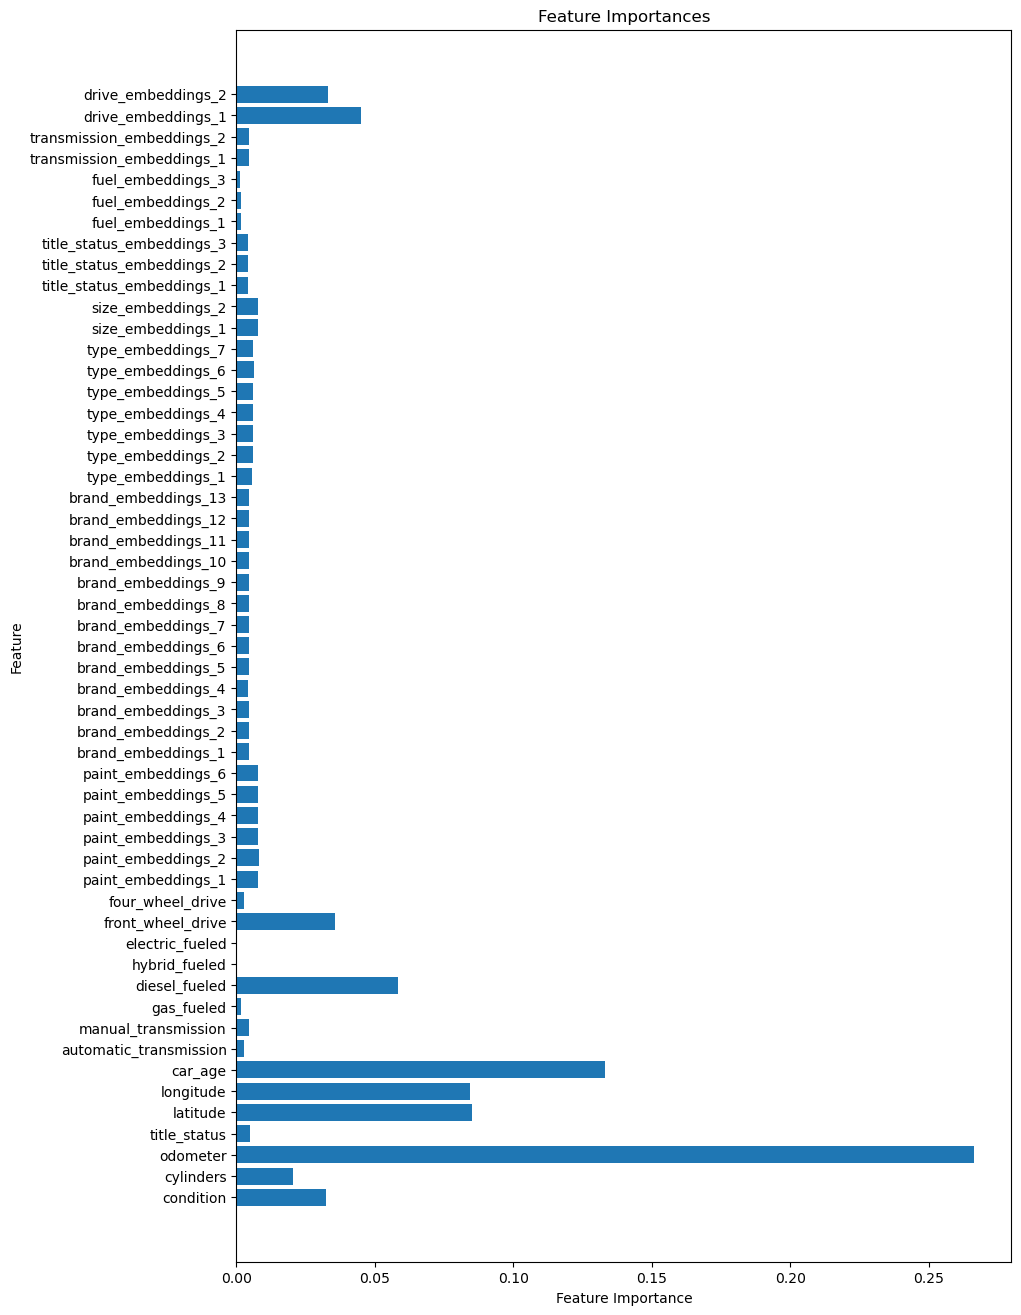

In [62]:
import matplotlib.pyplot as plt

# Assuming you already have 'feature_importances' calculated
# If not, make sure to calculate them using your model

# Get the names of the features
feature_names =X.columns
# Create a bar plot of feature importances
plt.figure(figsize=(10, 16))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [59]:
feature_importances

array([3.22006851e-02, 2.02990160e-02, 2.66547527e-01, 5.02611590e-03,
       8.49369370e-02, 8.43870109e-02, 1.33062979e-01, 2.89763809e-03,
       4.45178330e-03, 1.49449726e-03, 5.82166255e-02, 8.10558212e-05,
       6.36097034e-05, 3.57151818e-02, 2.81056027e-03, 7.72514592e-03,
       8.04354360e-03, 7.91488021e-03, 7.89492653e-03, 7.63463250e-03,
       7.62605417e-03, 4.46104366e-03, 4.42605795e-03, 4.61751170e-03,
       4.33911955e-03, 4.59971490e-03, 4.71199747e-03, 4.45083569e-03,
       4.52609964e-03, 4.49982579e-03, 4.64212249e-03, 4.48228066e-03,
       4.63380901e-03, 4.67113405e-03, 5.79209111e-03, 5.85679550e-03,
       6.06942477e-03, 6.06120103e-03, 6.06958325e-03, 6.28307650e-03,
       6.10297996e-03, 7.63326801e-03, 7.81408783e-03, 4.07789912e-03,
       4.14289673e-03, 4.34647176e-03, 1.55092667e-03, 1.60593192e-03,
       1.46859449e-03, 4.38899091e-03, 4.61382739e-03, 4.49035252e-02,
       3.31264696e-02])

In [63]:
y_pred = model.predict(X)

In [66]:
mape(y, y_pred)

26.321458922815864

In [67]:
X['condition']

0        5
1        1
2        2
3        5
4        5
        ..
27527    2
27528    5
27529    4
27530    5
27531    5
Name: condition, Length: 27532, dtype: int64

In [69]:
# Create a list of feature indices sorted by importance
sorted_feature_indices = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k], reverse=True)

# Select the top 'k' important features
num_features_to_keep = 10
selected_feature_indices = sorted_feature_indices[:num_features_to_keep]

print("Selected feature indices:", selected_feature_indices)

Selected feature indices: [2, 6, 4, 5, 10, 51, 13, 52, 0, 1]


In [74]:
important_features = []
for i in selected_feature_indices:
    important_features.append(X.columns[i])

In [75]:
important_features

['odometer',
 'car_age',
 'latitude',
 'longitude',
 'diesel_fueled',
 'drive_embeddings_1',
 'front_wheel_drive',
 'drive_embeddings_2',
 'condition',
 'cylinders']

In [77]:
cv_results_2 = baseline_models_cv(X[important_features], y)

# Display the Mean and Standard Deviation of MAPE for each model
for model_name, scores in cv_results_2.items():
    print(f"{model_name}: MAPE Mean = {scores.mean():.2f}%")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 822
[LightGBM] [Info] Number of data points in the train set: 22025, number of used features: 10
[LightGBM] [Info] Start training from score 13516.051896
[LightGBM] [Info] Number of data points in the train set: 22025, number of used features: 10
[LightGBM] [Info] Start training from score 13477.637321
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo

In [ ]:
catboost_model = cb.CatBoostRegressor(random_state=42, verbose=0, 'iterations'= 200)

# Define the hyperparameter grid to search over
param_grid = {
    'learning_rate': [0.05, 0.02, 0.03, 0.04],
    'depth': [6, 8, 10, 12],
    'l2_leaf_reg': [1, 3, 5]
}

# Perform 5-fold cross-validation with hyperparameter tuning
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(catboost_model, param_grid, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X[important_features], y)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_catboost_model = grid_search.best_estimator_

# Perform 5-fold cross-validation with the best model
cv_results = cross_val_score(best_catboost_model, X[important_features], y, cv=cv, scoring='neg_mean_absolute_error')

# Calculate the mean and standard deviation of the negative mean absolute error (MAE)
mean_mae = -cv_results.mean()
std_mae = cv_results.std()

# Calculate the mean and standard deviation of the Mean Absolute Percentage Error (MAPE)
mean_mape = mape(y, best_catboost_model.predict(X[important_features])).mean()
std_mape = mape(y, best_catboost_model.predict(X[important_features])).std()

# Display the results
print("Best Hyperparameters:", best_params)
print(f"MAE (Mean ± Std): {mean_mae:.2f} ± {std_mae:.2f}")
print(f"MAPE (Mean ± Std): {mean_mape:.2f}% ± {std_mape:.2f}%")